<a href="https://colab.research.google.com/github/happyhillll/Medical-Report-Generation/blob/main/Medical_Report_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2

In [42]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
os.chdir("/content/drive/MyDrive/하울스 1팀 : medical report generation/Self Case Study 2") 

각 파일에 몇개의 image와 report가 있는지 확인한다.

In [44]:
 print("there are {} number of reports in the data ".format(len(os.listdir("ecgen-radiology"))))
print("there are {} number of x-rays in the data ".format(len(os.listdir("NLMCXR_png")))) 

there are 3955 number of reports in the data 
there are 7471 number of x-rays in the data 


- image 가 report보다 개수가 많은 이유는 report 하나당 1개 이상의 x-ray 사진이 포함되어 있을 수 있기 때문이다. (정면, 측면)

##Extracting the medical reports from the xml file
- medical report는 xml 파일의 형식으로 저장되어 있다.
- 각각의 xml 파일에는 실질적인 report 이외에도 많은 데이터들이 들어있다. 
- 우리는 x-ray 사진들에 해당이 되는 알맞은 report가 학습이 되도록 x-ray를 고르는 작업이 필요하다.
- image의  id는 xml 파일에 포함되어있다.


In [45]:
from google.colab import files
files=files.upload()

In [46]:
from IPython.display import Image
Image("report sample.PNG", width=1000, height=800)

extracting findings,impression,and indication from these xml files as reports.
Also, extracting the image ids to get the x-ray corresponding to that report

In [40]:
#https://www.geeksforgeeks.org/xml-parsing-python/

import xml.etree.ElementTree as et #xml 파일을 읽기.
id=[] #빈 리스트 생성
finding=[]
count=[]
indication=[]
impression=[]

for report in tqdm(os.listdir("ecgen-radiology")):  # tqdm: 진행표시바 / os.listdir() : 지정된 디렉토리 내의 모든 파일과 list를 리턴
  #create element tree object
  tree=et.parse("ecgen-radiology/"+report)  #tree라는 파일 parsing하여 쓰기
  #get the root element
  root=tree.getroot()  #root는 xml 문서의 최상단 루트 태그를 가리키게 된다.
  '''
  <et의 xml 태그 구성 >
  tag : 해당 태그 이름
  text : 해당 태그의 값
  attrib : 해당 노드의 attribute 맵 (key,value)
  '''
  #inside the root element
  for child in root:  #root 안에서 찾기
      if child.tag == "MedlineCitation":  
          for each in child:  
              if each.tag == "Article":  
                  for i in each:
                      if i.tag == "Abstract":  #셋다 포함이 되어있는 tag의 텍스트: comparison,indication,findings,impression
                          for j in i:          

                            if j.get('Label')=='INDICATION':
                              indic=j.text    #j의 레이블이 indication이면 j의 텍스트를 indic에 저장
                              
                            if j.get("Label") == "FINDINGS":
                              find = j.text
                                
                            if j.get('Label')=='IMPRESSION':
                              impr=j.text
                              
                                       
  image_count=0 #this is to find the number of x-rays in each report 
  for img_id in root.findall("parentImage"): #"parentImage"가 담겨있는 모든 열에서 하나씩
    id.append(img_id.get("id")+".png")   #비어있는 리스트 id에 parentImage열 id(/parentImage/@id)를 불러와서 "아이디.png"로 바꿔서 append
    #이때 이미지가 두 개이면, id도 두 개
    finding.append(find)       #finding 변수에 find append
    impression.append(impr)
    indication.append(indic)
    image_count+=1     #for문 한 번이 끝나면 image를 하나 count 해줌
  count.append(image_count)  

100%|██████████| 3955/3955 [00:06<00:00, 570.08it/s]


In [47]:
from IPython.display import Image
Image("reprt 2.PNG", width=1000, height=800) 

In [48]:
df=pd.DataFrame()
patient_id=[i[:-9] for i in id] #parent
df["patient_id"]=patient_id
df["image_id"]=["NLMCXR_png/"+ i for i in id]
df["finding"]=finding
df["impression"]=impression
df["indication"]=indication

print(df.shape)
df

(7470, 5)


,patient_id,image_id,finding,impression,indication
0,CXR3696_IM-1846,NLMCXR_png/CXR3696_IM-1846-1001.png,None,Heart size is normal and lungs are clear. Stab...,preop for XXXX surgery XXXX surgery on jaw
1,CXR3696_IM-1846,NLMCXR_png/CXR3696_IM-1846-1002.png,None,Heart size is normal and lungs are clear. Stab...,preop for XXXX surgery XXXX surgery on jaw
2,CXR3681_IM-1833-0001,NLMCXR_png/CXR3681_IM-1833-0001-0001.png,There are lower lung volumes. There is central...,No acute abnormality identified.,Right-sided chest pain and shortness of breath.
3,CXR3681_IM-1833-0001,NLMCXR_png/CXR3681_IM-1833-0001-0002.png,There are lower lung volumes. There is central...,No acute abnormality identified.,Right-sided chest pain and shortness of breath.
4,CXR3676_IM-1829-0001,NLMCXR_png/CXR3676_IM-1829-0001-0001.png,The cardiomediastinal silhouette appears irreg...,1. Redemonstration of diffuse bilateral pulmon...,XXXX-year-old male with XXXX.
...,...,...,...,...,...
7465,CXR1851_IM-0553,NLMCXR_png/CXR1851_IM-0553-2001.png,Heart size is normal. No focal airspace consol...,No acute cardiopulmonary findings. .,XXXX-year-old male with XXXX and dyspnea.
7466,CXR1877_IM-0568,NLMCXR_png/CXR1877_IM-0568-1001.png,Heart size normal. Lungs are clear. XXXX are n...,Normal chest,XXXX
7467,CXR1877_IM-0568,NLMCXR_png/CXR1877_IM-0568-2001.png,Heart size normal. Lungs are clear. XXXX are n...,Normal chest,XXXX
7468,CXR186_IM-0558,NLMCXR_png/CXR186_IM-0558-1001.png,"Cardiac size, mediastinal contour, and pulmona...",No acute cardiopulmonary abnormalities. No evi...,"XXXX year old woman, question swallowed foreig..."


In [49]:
#check the lengths of reports
length=[]
for report in df["finding"]:
  try:
    length.append(len(report.split()))
  except:
    pass
length=np.array(length)
print("the mean lengths of reports is ",np.mean(length))
print("the 80th percentile lengths of reports is ",np.percentile(length,80))
print("the 90th percentile lengths of reports is ",np.percentile(length,90))
print("the 99th percentile lengths of reports is ",np.percentile(length,99))
print("the maximum value of lengths of reports is ",np.max(length))

the mean lengths of reports is  31.32164375096555
the 80th percentile lengths of reports is  41.0
the 90th percentile lengths of reports is  50.0
the 99th percentile lengths of reports is  79.0
the maximum value of lengths of reports is  169


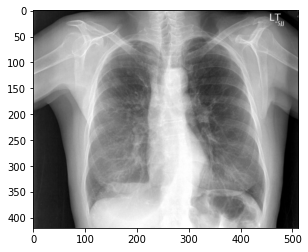

FINDINGS: Cardiomediastinal silhouettes are within normal limits. Lungs are clear without focal consolidation, pneumothorax, or pleural effusion. Vague nodular density right upper lobe overlying the right anterior 2nd and posterior 6th ribs. This could represent healing fracture or superimposed structures. Bony thorax is unremarkable.
IMPRESSION: 1. No acute cardiopulmonary abnormalities. 2. Vague left upper lobe nodular density as described above. Further imaging XXXX may be helpful.
INDICATION: XXXX-year-old female with XXXX.
****************************************************************************************************


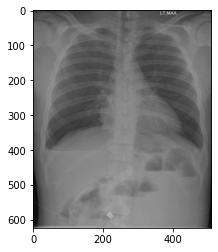

FINDINGS: None
IMPRESSION: Persistent 8mm pneumothorax with small amount of pleural effusion. Heart size normal. Enteric tube tip in the stomach. Midline abdominal clips. XXXX in the right upper quadrant. Bullet overlies L3.
INDICATION: followup pneumothorax
****************************************************************************************************


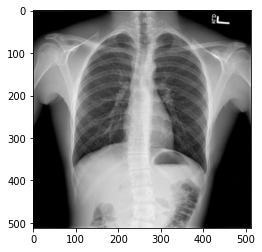

FINDINGS: Lungs are clear. No focal infiltrate or effusion. No pneumothorax. Heart and mediastinal contours within normal limits. Visualized osseous structures intact.
IMPRESSION: No acute cardiopulmonary disease.
INDICATION: XXXX-year-old with chest pain
****************************************************************************************************


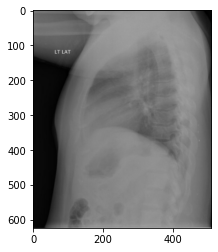

FINDINGS: The cardiomediastinal contours are within normal limits. Pulmonary vasculature is unremarkable. There is no focal airspace opacity. No pleural effusion or pneumothorax is seen. No acute bony abnormality is identified.
IMPRESSION: No acute cardiopulmonary abnormality.
INDICATION: History of XXXX with XXXX.
****************************************************************************************************


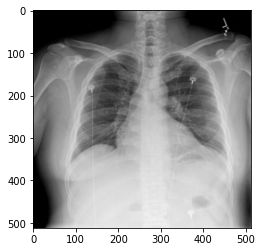

FINDINGS: The lungs and pleural spaces show no acute abnormality. Heart size is upper limits of normal, pulmonary vascularity within normal limits. .
IMPRESSION: 1. No acute pulmonary abnormality.
INDICATION: Pain with syncope. Blurry vision.
****************************************************************************************************


In [50]:
#print some sample x-rays and findings
a=np.random.choice(range(7470),5)
for each in a:
  img=cv2.imread(df.iloc[each]["image_id"])
  plt.imshow(img)
  plt.show()
  print("FINDINGS:",df.iloc[each]["finding"])
  print("IMPRESSION:",df.iloc[each]["impression"])
  print("INDICATION:",df.iloc[each]["indication"])
  print("*"*100)

In [51]:
#finding the number of reports were findings is none
none=sum(df["finding"].isnull().values.ravel())
print("there are {} number of records where finding is none".format(none))

there are 997 number of records where finding is none


In [52]:
for i in range(df.shape[0]):
  if finding[i] is None:
    
    finding[i]=impression[i]
    

df["finding"]=finding

In [53]:
none=sum(df["finding"].isnull().values.ravel())
print("there are {} number of records where finding is none".format(none))

there are 40 number of records where finding is none


In [54]:
df=df.dropna()
none=sum(df["finding"].isnull().values.ravel())
print("there are {} number of records where finding is none".format(none))
df=df.drop(["impression","indication"],axis=1)

there are 0 number of records where finding is none


In [55]:
df

,patient_id,image_id,finding
0,CXR3696_IM-1846,NLMCXR_png/CXR3696_IM-1846-1001.png,Heart size is normal and lungs are clear. Stab...
1,CXR3696_IM-1846,NLMCXR_png/CXR3696_IM-1846-1002.png,Heart size is normal and lungs are clear. Stab...
2,CXR3681_IM-1833-0001,NLMCXR_png/CXR3681_IM-1833-0001-0001.png,There are lower lung volumes. There is central...
3,CXR3681_IM-1833-0001,NLMCXR_png/CXR3681_IM-1833-0001-0002.png,There are lower lung volumes. There is central...
4,CXR3676_IM-1829-0001,NLMCXR_png/CXR3676_IM-1829-0001-0001.png,The cardiomediastinal silhouette appears irreg...
...,...,...,...
7465,CXR1851_IM-0553,NLMCXR_png/CXR1851_IM-0553-2001.png,Heart size is normal. No focal airspace consol...
7466,CXR1877_IM-0568,NLMCXR_png/CXR1877_IM-0568-1001.png,Heart size normal. Lungs are clear. XXXX are n...
7467,CXR1877_IM-0568,NLMCXR_png/CXR1877_IM-0568-2001.png,Heart size normal. Lungs are clear. XXXX are n...
7468,CXR186_IM-0558,NLMCXR_png/CXR186_IM-0558-1001.png,"Cardiac size, mediastinal contour, and pulmona..."


Text(0.5, 1.0, 'number of image per patient ')

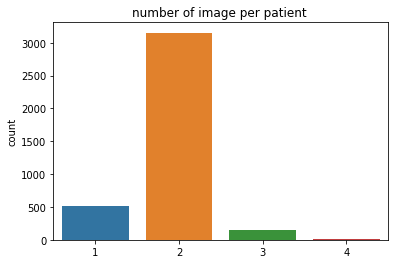

In [56]:
d=dict()
for patient in df["patient_id"]:
  if patient in d:
    d[patient]+=1
  else:
    d[patient]=1

count=list(d.values())
sns.countplot(count)
plt.title("number of image per patient ")

In [57]:
#https://www.geeksforgeeks.org/xml-parsing-python/

import xml.etree.ElementTree as et
img=[]

for report in tqdm(os.listdir("ecgen-radiology")):
  #create element tree object
  tree=et.parse("ecgen-radiology/"+report)
  
  root=tree.getroot()
  
  
  if len(root.findall("parentImage"))>3:
    for img_id in root.findall("parentImage"):
    
      img.append(img_id.get("id")+".png")
  
    break

  7%|▋         | 258/3955 [00:00<00:04, 784.37it/s]


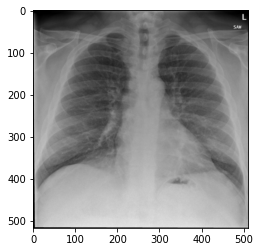

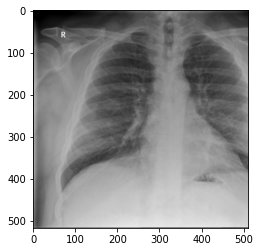

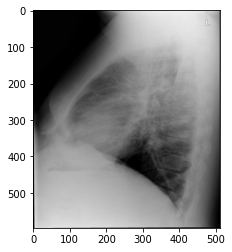

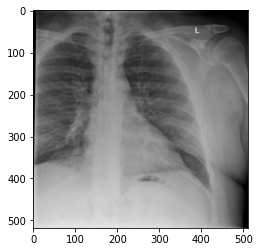

In [58]:
for i in img:
  image=cv2.imread("NLMCXR_png/"+i)
  plt.imshow(image)
  plt.show()

In [59]:
d=dict() #where key is the patient id and value is the images
d1=dict() # where key is the patient id and value is the report or findings
for row in range(df.shape[0]):
  if df.iloc[row]["patient_id"] in d:
    d[df.iloc[row]["patient_id"]].append(df.iloc[row]["image_id"])
  else:
    d[df.iloc[row]["patient_id"]]=[df.iloc[row]["image_id"]]

  d1[df.iloc[row]["patient_id"]]=[df.iloc[row]["finding"]]

In [60]:
#images and findings associated with the first patient
print(d["CXR3676_IM-1829-0001"])
print(d1["CXR3676_IM-1829-0001"])

['NLMCXR_png/CXR3676_IM-1829-0001-0001.png', 'NLMCXR_png/CXR3676_IM-1829-0001-0002.png']
["The cardiomediastinal silhouette appears irregular secondary to the diffuse bilateral pulmonary interstitial disease. The thoracic aorta is tortuous. Calcified lymph XXXX are demonstrated in the left hilum. No focal pulmonary consolidation. Diffuse increased bilateral pulmonary interstitial markings, consistent with the patient's history of known pulmonary fibrosis, with relative sparing of the bilateral lung apices. No pneumothorax or pleural effusion demonstrated. The thoracic spine appears intact."]


In [61]:
image1=[]
image2=[]
report=[]
patient_id=[]
for patient in d.keys():

  #if there is only one image for a person
  if len(d[patient])==1:
    img1=d[patient][0]
    img2=d[patient][0]

  #if there are two images for a person
  elif len(d[patient])==2:
    img1=d[patient][0]
    img2=d[patient][1]
  
  #if there are three images for a person
  elif len(d[patient])==3:
    a=np.random.choice([0,1,2],2)
    img1=d[patient][a[0]]
    img2=d[patient][a[1]]

  #if there are four images for a person
  elif len(d[patient])==4:
    a=np.random.choice([0,1,2,3],2)
    img1=d[patient][a[0]]
    img2=d[patient][a[1]]
    
  image1.append(img1)
  image2.append(img2)
  report.append(d1[patient][0])
  patient_id.append(patient)

In [62]:
df_dash=pd.DataFrame()
df_dash["patient_id"]=patient_id
df_dash["image1"]=image1
df_dash["image2"]=image2
df_dash["report"]=report
df_dash

,patient_id,image1,image2,report
0,CXR3696_IM-1846,NLMCXR_png/CXR3696_IM-1846-1001.png,NLMCXR_png/CXR3696_IM-1846-1002.png,Heart size is normal and lungs are clear. Stab...
1,CXR3681_IM-1833-0001,NLMCXR_png/CXR3681_IM-1833-0001-0001.png,NLMCXR_png/CXR3681_IM-1833-0001-0002.png,There are lower lung volumes. There is central...
2,CXR3676_IM-1829-0001,NLMCXR_png/CXR3676_IM-1829-0001-0001.png,NLMCXR_png/CXR3676_IM-1829-0001-0002.png,The cardiomediastinal silhouette appears irreg...
3,CXR3671_IM-1827,NLMCXR_png/CXR3671_IM-1827-1001.png,NLMCXR_png/CXR3671_IM-1827-3001.png,Stable cardiomediastinal silhouette. Mild patc...
4,CXR3677_IM-1830,NLMCXR_png/CXR3677_IM-1830-1001.png,NLMCXR_png/CXR3677_IM-1830-2001.png,Heart size is within normal limits. Aorta is t...
...,...,...,...,...
3815,CXR1844_IM-0547,NLMCXR_png/CXR1844_IM-0547-1001.png,NLMCXR_png/CXR1844_IM-0547-2001.png,Normal cardiomediastinal contours. Hyperexpans...
3816,CXR1871_IM-0564,NLMCXR_png/CXR1871_IM-0564-1001.png,NLMCXR_png/CXR1871_IM-0564-2001.png,The cardiomediastinal contours are within norm...
3817,CXR1851_IM-0553,NLMCXR_png/CXR1851_IM-0553-1001.png,NLMCXR_png/CXR1851_IM-0553-2001.png,Heart size is normal. No focal airspace consol...
3818,CXR1877_IM-0568,NLMCXR_png/CXR1877_IM-0568-1001.png,NLMCXR_png/CXR1877_IM-0568-2001.png,Heart size normal. Lungs are clear. XXXX are n...


#Preprocessing the text data

In [63]:
# some sample report
print(df_dash["report"].values[:10])

['Heart size is normal and lungs are clear. Stable 5 mm right midlung perform granuloma'
 'There are lower lung volumes. There is central bronchovascular crowding. Volume loss in the medial right upper lobe seen on XXXX is not as well-demonstrated on radiography. No lobar consolidation. No pleural effusion or pneumothorax.'
 "The cardiomediastinal silhouette appears irregular secondary to the diffuse bilateral pulmonary interstitial disease. The thoracic aorta is tortuous. Calcified lymph XXXX are demonstrated in the left hilum. No focal pulmonary consolidation. Diffuse increased bilateral pulmonary interstitial markings, consistent with the patient's history of known pulmonary fibrosis, with relative sparing of the bilateral lung apices. No pneumothorax or pleural effusion demonstrated. The thoracic spine appears intact."
 'Stable cardiomediastinal silhouette. Mild patchy right upper lobe opacities, similar to slightly improved from XXXX. Left lung clear. No pleural effusion or pneumo

In [64]:
#convert into lowercase
finding=df_dash["report"].values
for idx in tqdm(range(len(finding))):
    
    lower=finding[idx].lower()
    finding[idx]=lower
  
df_dash["report"]=finding


100%|██████████| 3820/3820 [00:00<00:00, 482190.96it/s]


In [65]:
#Now we need to expand the contractions like won't, can't, don't etc.
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"i'd": "i had / i would",
"i'd've": "i would have",
"i'll": "i shall / I will",
"i'll've": "i shall have / i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}



finding=df_dash["report"].values
for idx in tqdm(range(len(finding))):
  list_of_words=finding[idx].split(" ")
  
  sentence=""
  for i in list_of_words:
    
    if len(i)>2:
      
      if i in list(contractions.keys()):
        wrd=contractions[i]
      else:
        wrd=i
      
      sentence+=wrd+" "
    else:
      continue
  finding[idx]=sentence

100%|██████████| 3820/3820 [00:00<00:00, 9151.54it/s]


In [66]:
'''Now we remove all the special characters, and digits from the report. also remove the extra spaces in the sentence. Also there
are some words like xxx. These words are not giving any additional meaning to the report. So we remove those words
'''

for idx in tqdm(range(len(finding))):
    
  report=re.sub("[^a-z.]"," ",finding[idx])
  report=re.sub("xx+","",report)
  report=re.sub(r'\b\w{1,2}\b',"",report) #some unwanted words came up which are having lenbth<2. They are also removed
  report=re.sub("\s\s+"," ",report)
  finding[idx]=report 
print("\n")

100%|██████████| 3820/3820 [00:00<00:00, 41055.30it/s]

In [67]:
for i in finding[:10]:
  print(i)

heart size normal and lungs are clear. stable right midlung perform granuloma 
there are lower lung volumes. there central bronchovascular crowding. volume loss the medial right upper lobe seen not well demonstrated radiography. lobar consolidation. pleural effusion pneumothorax. 
the cardiomediastinal silhouette appears irregular secondary the diffuse bilateral pulmonary interstitial disease. the thoracic aorta tortuous. calcified lymph are demonstrated the left hilum. focal pulmonary consolidation. diffuse increased bilateral pulmonary interstitial markings consistent with the patient history known pulmonary fibrosis with relative sparing the bilateral lung apices. pneumothorax pleural effusion demonstrated. the thoracic spine appears intact. 
stable cardiomediastinal silhouette. mild patchy right upper lobe opacities similar slightly improved from . left lung clear. pleural effusion pneumothorax. 
heart size within normal limits. aorta tortuous. remainder the cardiomediastinal silho

In [68]:
df_dash["report"]=finding
df_dash.to_csv("data.csv")